# PAA Project, a.y. 2015/2016
## Average number of checks for Quicksort

Authors:
- Tommaso Papini, 5537529 ([mail][mail-tom] [Github][git-tom])
- Gabriele Bani, 5719258 ([mail][mail-gab] [Github][git-gab])

[mail-tom]: mailto:tommaso.papini1@stud.unifi.it
[git-tom]: https://github.com/oddlord
[mail-gab]: mailto:gabriele.bani@stud.unifi.it
[git-gab]: https://github.com/brnibani


### Introduction
The goal of this notebook is to provide an explanation on how to get the formula to calculate the (exact) average number of checks done by the [Quicksort][quicksort] algorithm on arrays of length $n$.

In particular this notebook will be very [symbolic computation][symb-comp] oriented, which means that most of the passages needed to get to the final form of our formula will be done using a symbolic computation package for [Python][python], called [sympy][sympy].

With sympy we'll be able to rewrite and manipulate our recurrence to finally obtain the goal function that computes the average number of checks, given the array length $n$.

[quicksort]: https://en.wikipedia.org/wiki/Quicksort
[symb-comp]: https://en.wikipedia.org/wiki/Symbolic_computation
[python]: https://www.python.org/
[sympy]: http://www.sympy.org/en/index.html

### Some initial imports
Before with start with the cool stuff, let's first import the basic packages we're gonna need for the rest of the notebook!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy
from sympy import *
from sympy.abc import x, n, z, t, j, k
from sympy.combinatorics import *
import timeit

%matplotlib inline
init_printing()

The call $init\_printing()$ is to allow sympy outputs to be displayed with LaTeX style.

### Quicksort implementation with checks counting
Here we provide the Quicksort implementation that will be used for the rest of the notebook.

As you might know, the number of checks/swaps might vary greatly from one implementation to another of the same algorithm, so it's mandatory to set in stone right away which specific implementation we're gonna use.

In this implementation the inputs $v$, $l$ and $r$ represents, respectively, the array to be sorted and the left and right indexes of the array.
The pivot is always the rightmost element of the array, i.e. $v[r]$.

Also, we included a checks counting, so that later on we can also run some simulation to gather some actual number to compare with the function output (and check if the results are consistent!).
The algorithm will return the number of checks done $nc$.

In [2]:
def quick(v,l,r):
    nc = 0;
    if (r - l) >= 0:
        p = v[r]
        i = l - 1
        j = r
        while i < j:
            i += 1
            nc += 1
            while v[i] < p:
                i += 1
                nc += 1
            j -= 1
            nc += 1
            while l <= j and p < v[j]:
                j -= 1
                nc += 1
            if i < j:
                a = v[i]
                v[i] = v[j]
                v[j] = a
        a = v[i]
        v[i] = p
        v[r] = a
        nc += quick(v,l,i-1)
        nc += quick(v,i+1,r)
    return nc

### Closed form function
Let's define the closed form of the function we're looking for, just to give a glimpse of what we're doing with a few examples.

The function is
$$C_n = 2(n+1)(H_{n+1}-1),$$
where $C_n$ is the average checks with arrays of length $n$ and $H_{n}$ is the $n$-th [harmonic number][harm-num].

[harm-num]: https://en.wikipedia.org/wiki/Harmonic_number

In [3]:
def checks_quicksort(n):
    return 2*(n+1)*(harmonic(n+1).evalf()-1)

Getting this closed form of $C_n$ is the main goal of this notebook.

### A couple of examples
We provide here a couple of examples where we compare the result of the closed form function defined above with the actual number of checks done by our implementation of Quicksort on a random array.

In [4]:
random_perm = np.random.permutation(20)
print ("Random array: %s" % (random_perm))
checks = quick(random_perm,0,19)
print ("Array after Quicksort: %s" % (random_perm))
print ("Quicksort count: %.5f; closed-form: %.5f" % (checks, checks_quicksort(20)))

Random array: [ 6 18  3  9 19 17  2 15  5 12  4  1 16 10 11  8  7 13 14  0]
Array after Quicksort: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Quicksort count: 124.00000; closed-form: 111.10507


In [5]:
random_perm = np.random.permutation(4)
print ("Random array: %s" % (random_perm))
checks = quick(random_perm,0,3)
print ("Array after Quicksort: %s" % (random_perm))
print ("Quicksort count: %.5f; closed-form: %.5f" % (checks, checks_quicksort(4)))

Random array: [1 3 0 2]
Array after Quicksort: [0 1 2 3]
Quicksort count: 12.00000; closed-form: 12.83333


### Main recurrence
Let the dance commence!

The first thing we need is to define a recurrence that describes the average number of checks done by our Quicksort implementations.

Why a recurrence, you might ask? because the Quicksort is a recursive algorithm and recurrences are the mathematical counterpart of recursive algorithms: a recursive algorithm is described by a recurrence and a recurrence can be evaluated by running a recursive algorithm.

But evaluating a recurrence can be sometimes very expensive, in terms of both space and time. So what we usually try to do is to **solve** the recurrence, which means try to rewrite and manipulate the recurrence until we obtain a closed form.
Since the closed form is more direct and does not involve calling the same function over and over multiple times, it's often preferrable to the recurrence evaluation as it'll save precious resources.

To obtain the closed form of the recurrence that describes the average number of checks in the Quicksort is the goal of this notebook.
In particular we'll see two different approaches to get from the recurrence to the closed form: the *difference method* and the *genetaring function method*.

#### Getting the recurrence
So let's start with defining the recurrence that describes the average number of checks done by our Quicksort implementation.

How many checks does a single Quicksort call do?
$$n+1$$
In fact we can notice that our algorithm does a check each time the indexes $i$ and $j$ are increased/decreased. Since these indexes have to scan all the elements that are not the pivot until they cross, we have $n-1$ checks (for $n-1$ elements that are not the pivot) plus $2$ checks to let the indexes cross, for a total of $n+1$.

Now we have to consider the checks done by the two recursive calls.
If the pivot is $k$, then the checks of the two calls will be given by
$$C_{k-1}+C_{n-k}$$

But since we're analyzing the average number of checks, we have to consider every possible configuration we can find. The number of checks done by the two recursive calls depends on the value of the pivot, i.e. the rightmost element, that can have $n$ different values (from $1$ to $n$).

Also, among the $n!$ possible permutations, only $(n-1)!$ have $k$ in the last position. This means that the probability of having a combination with $k$ as pivot is:
$$\frac{(n-1)!}{n!}=\frac{1}{n}$$

If we put everything together we finally obtain the recurrence:
$$C_n = n+1+\frac{1}{n}\sum_{k=1}^{n}(C_{k-1}+C_{n-k})$$
With initial contition $C_0 = 0$.

Before we can move on to the next step, we can notice that inside the summation, each recursive call appears exactly twice and also that the actual indexes of the recursive calls range from $0$ to $n-1$. This means that:
$$\sum_{k=1}^{n}(C_{k-1}+C_{n-k}) = 2\sum_{k=0}^{n-1}C_k$$

That said, we can rewrite the recurrence in a much simpler way:
$$C_n = n+1 + \frac{2}{n}\sum_{k=0}^{n-1}C_k$$

#### Python version
Below we provide a python implementation of the above recurrence, so that we can later compare it with the results of the closed form function and the actual checks from the algoritms.

In [6]:
def C_py(n):
    if n == 0:
        return 0
    else:
        Cn = 0.0
        for k in range(0, n):
            Cn += C_py(k)
        return n+1+(2.0/n)*Cn

In [7]:
random_perm = np.random.permutation(20)
quicksort_count = quick(random_perm,0,19)
checks = checks_quicksort(20)
rec_quicksort = C_py(20)
print ("Quicksort count: %.5f; closed-form: %.5f; recurrence: %.5f" % (quicksort_count, checks, rec_quicksort))

Quicksort count: 103.00000; closed-form: 111.10507; recurrence: 111.10507


#### sympy version
Let's start using sympy, the python package for symbolic computation.

We start by defining the recurrence as seen above, in sympy sintax.

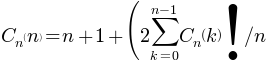

In [8]:
Cn = Function('C_n')
base_rec = Eq(Cn(n), n+1+(2/n)*Sum(Cn(k), (k, 0, n-1)))
base_rec

Please observe that, in order to manipulate this succession with sympy, we have to express $C_n$ as a function, i.e. with the parenthesis notation. Also, to distinguish it from a similar notation that we'll introduce further on the notebook, we'll also keep the subscript $n$.

So, from this point on, we'll assume that $C_k = C_n(k)$.

#### Are we lucky?
sympy provides a function called *rsolve*, which tries to automatically solve a recurrence and calculate it's closed form.

Let's try to see if we are lucky and our recurrence is easy enough to be solved automatically by sympy.

In [9]:
print (rsolve(base_rec, Cn(n), {Cn(0):0}))

None


Nope... :(

So let's begin with the first approach, the *difference method*.

### Recurrence solving: difference method
The first method we're gonna use to solve the recurrence is called *difference method*.

The idea of the difference method is to express the recurrence in two generic successive points, let them be $n-1$ and $n$, and then express the difference of the recurrences in these two point, with the hope to obtain a simpler recurrence.

#### Auxiliary function to apply the same operation between a number and the two sides of an Eq
Before we start, let's define an useful auxiliary function that lets us apply a binary operation $op$ to the two sides of an equation $eq$ (first argument of $op$) and a number $n$ (second argument of $op$).

In [10]:
def op_eq_n(eq, n, op):
    return Eq(op(eq.lhs, n), op(eq.rhs, n))

#### Multiply by $n$ both sides
We use that auxiliary function right away, to multiply both sides of the equation by $n$.

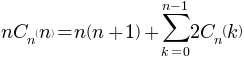

In [11]:
base_rec2 = op_eq_n(base_rec, n, lambda x,y: x*y).simplify()
base_rec2

#### Auxiliary function to factor a Sum and substitute
Since in sympy there's currently no supported feature to factor constants out of Sums, we need to implement a small function that does that, as suggested [here][factor-sum].

[factor-sum]: https://github.com/sympy/sympy/issues/7902

In [12]:
def factor_sum_subs(eq, old_sum):
    con, dep = factor_terms(old_sum.function.as_independent(*old_sum.variables));
    new_sum=con*Sum(dep, *old_sum.args[1:])
    return eq.subs(old_sum, new_sum)

#### Let's use it to factor that $2$ out of the Sum
That $2$ inside the summation is quite ugly, let's take it out with $factor\_sum\_subs$!

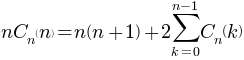

In [13]:
base_rec3 = factor_sum_subs(base_rec2, Sum(2*Cn(k), (k, 0, n-1)))
base_rec3

#### The above is valid for every value of $n$, so it's valid for $n-1$ as well
Here we simply substitute $n$ with $n-1$ in the recurrence. This is legit since the recurrence we defined is valid for all $n$.

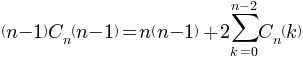

In [14]:
base_rec3_prev = base_rec3.subs(n, n-1)
base_rec3_prev

#### Auxiliary function to apply an operation to two Eqs sidewise
Now we need an auxiliary function that is similar to $op_eq_n$ but where the operation $op$ is applied between two equations sidewise and not between an equation and a number.

In [15]:
def op_eqs(eq1, eq2, op):
    return Eq(op(eq1.lhs, eq2.lhs), op(eq1.rhs, eq2.rhs))

#### Application of the difference method
In this passage we apply the idea of the *difference method*: we have the recurrence expressed in $n$ and in $n-1$ and we express the difference between the two now.

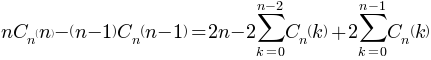

In [16]:
diff_rec = op_eqs(base_rec3, base_rec3_prev, lambda x,y: x-y).simplify()
diff_rec

#### Auxiliary function to extract the last term of a summation and substitute inside an Eq
Now that we need some advanced manipulation power, we write a function that extracts the last term out of a summation and substitute the new summation (plus the last term explicited) inside an equation.

In [17]:
def extract_last_term_subs(eq, old_sum):
    sum_args = old_sum.args
    f = sum_args[0]
    indexes = sum_args[1]
    new_sum = Sum(f, (indexes[0], indexes[1], indexes[2]-1)) + f.subs(indexes[0], indexes[2])
    return eq.subs(old_sum, new_sum)

#### Extract term $n-1$ and simplify summations
With the above function, we can now extract the term with index $n-1$ from the second summation. This way, the two resulting summations in the recurrence will be the opposite one another and will simplify mutually.

In [18]:
diff_rec2 = extract_last_term_subs(diff_rec, Sum(Cn(k), (k, 0, n-1))).simplify().doit()
diff_rec2

#### Move $(n-1)C(n-1)$ to the other side and group by $C(n-1)$
Here we move the term $(n-1)C(n-1)$ to the right side of the equation so we can factor by $C(n-1)$.

In [19]:
new_rec = op_eq_n(diff_rec2, (n-1)*Cn(n-1), lambda x,y: x+y).simplify().factor(Cn(n-1))
new_rec

#### Divide both sides by $n(n-1)$

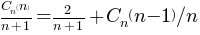

In [20]:
div_rec  = apart(op_eq_n(new_rec, n*(n+1), lambda x,y: x/y), Cn(n-1))
div_rec

#### Let's unfold!
We can notice now that the last term $\frac{1}{n}C_n(n-1)$ is exactly the term of the left side of the equation but calculated on the previous point.
So we can now calculate the same recurrence for $\frac{1}{n}C_n(n-1)$ and substitute to $\frac{1}{n}C_n(n-1)$.

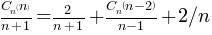

In [21]:
div_rec2 = div_rec.subs(Cn(n-1)/n, div_rec.subs(n, n-1).rhs)
div_rec2

We can do the same with $\frac{C_n(n-2)}{n-1}$.

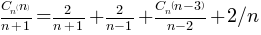

In [22]:
div_rec3 = div_rec2.subs(Cn(n-2)/(n-1), div_rec.subs(n, n-2).rhs)
div_rec3

And so on and so forth...

#### All the way to $C_n(0)$
We unfold the summation as shown above until we reach $C_n(0)$, i.e. when we obtain
$$\frac{C_n(n)}{n+1} = \frac{2}{n+1} + \frac{2}{n} + \frac{2}{n-1} + \dots + \frac{2}{n-n+2} + \frac{C_n(0)}{n-n+1}.$$
Unfortunately sympy does not provide any summation unfold operator, so we are bound to manually rewrite the recurrence.

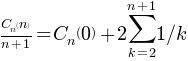

In [23]:
div_rec_final = factor_sum_subs(Eq(div_rec.lhs, Sum(2/k, (k, 2, n+1))+Cn(0)/(n-n+1)), Sum(2/k, (k, 2, n+1)))
div_rec_final

#### But $C_n(0)=0$
We know that $C_n(0) = 0$, as it's the initial condition we set for our recurrence.

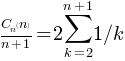

In [24]:
div_rec_final2 = div_rec_final.subs(Cn(0), 0)
div_rec_final2

#### Auxiliary function to add a missing first term in a summation and substitute inside an Eq
Now we need another auxiliary function that adds a missing first term inside a summation, adding that same term but with opposite sign outside the summation to balance everything.

In [25]:
def add_missing_first_term_subs(eq, old_sum):
    sum_args = old_sum.args
    f = sum_args[0]
    indexes = sum_args[1]
    new_sum = Sum(f, (indexes[0], indexes[1]-1, indexes[2])) - f.subs(indexes[0], indexes[1]-1)
    return eq.subs(old_sum, new_sum)

#### Let's add the missing first term to the summation above
We can now add the missing first term to the previous summation. The reason we do this will soon be clear.

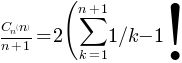

In [26]:
div_rec_final3 = add_missing_first_term_subs(div_rec_final2, Sum(1/k, (k, 2, n+1))).factor()
div_rec_final3

#### That summation above is the harmonic series!
By definition of [harmonic series][harm-series], we have that
$$\sum_{k=1}^{n} \frac{1}{k} = H_n,$$
so we can rewrite the summation above as $H_{n+1}.$

[harm-series]: https://en.wikipedia.org/wiki/Harmonic_series_(mathematics)

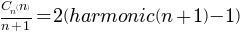

In [27]:
div_rec_final_harm = div_rec_final3.doit().rewrite(harmonic).factor()
div_rec_final_harm

#### Let's finally obtain the closed form
With this last step, we finally obtain the closed form of the function $C_n(n)$ that calculates the average number of checks done by the Quicksort on arrays of length $n$ by multiplying both sides by $(n+1)$.

In [28]:
closed_form_diff = op_eq_n(div_rec_final_harm,n+1,lambda x,y: x*y).factor()
closed_form_diff

### Recurrence solving: generating function method
The second method we see is the *[generating function][gen-func] method*.

The idea of this method is to calculate a closed form of the function $\mathcal{G}(C_n(n), t)$ through the application of a finite number of rules, or principles, that applies to generating function.

Once we have the closed form of $\mathcal{G}(C_n(n), t)$ we have two choices: we either stop there and use the series expansion of $\mathcal{G}(C_n(n), t)$ to check if the coefficients coincide with $C_n(n)$, for some fixed $n$, or we can go even further and apply the operator $[t^n]$, called "coefficient of", to $\mathcal{G}(C_n(n), t)$, in order to obtain the closed form for $C_n(n)$.

[gen-func]: https://en.wikipedia.org/wiki/Generating_function

#### Let's start again from our base recurrence

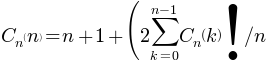

In [29]:
base_rec

#### Multiply both sides by $n$, as before

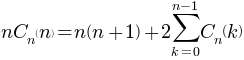

In [30]:
base_rec3

#### Let's define the $\mathcal{G}$ function
We need to define the *generating function* operator $\mathcal{G}$.

$\mathcal{G}$ is a function in two variables, a numeric succession, like our $C_n(n)$, and a placeholder symbol $t$, such that:
$$\mathcal{G}(C_n(n), t) = \sum_{k=0}^{+\infty}C_n(n)\cdot t^k.$$

In [31]:
G = Function('\mathcal{G}');
G(Cn(n), t)

#### Identity principle
The *identity principle* states that if
$$a_n = b_n \;\forall n,$$
then
$$\mathcal{G}(a_n, t) = \mathcal{G}(b_n, t).$$

In [32]:
def identity_principle(eq):
    return Eq(G(eq.lhs, t), G(eq.rhs, t))

#### Apply the identity principle to our recurrence
We can easily check that the successions on each side of our recurrence are equal for each $n$ (even for $n=0$ we get $0=0$, so no adjustment is needed). This means we can apply the identity principle and move on to the generating function world.

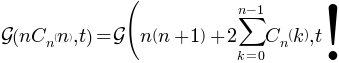

In [33]:
g_rec = identity_principle(base_rec3)
g_rec

#### Let's define the linearity property of $G$
One of the basic properties of generating functions is the *linearity*, which states that
$$\mathcal{G}(\alpha a_n + \beta b_n, t) = \alpha\mathcal{G}(a_n, t) + \beta\mathcal{G}(b_n, t).$$

In [34]:
def linearity(eq, g):
    x = Wild('x', exclude=[n])
    a = Wild('a')
    y = Wild('y', exclude=[n])
    b = Wild('b')
    match = g.match(G(x*a+y*b, t))
    return eq.subs(g, x*G(a, t)+y*G(b, t)).xreplace(match)

#### And apply it to the right side
Let's apply the linearity principle to the right side of the equation in order to break the inner sum into two generating functions (and also bring that $2$ outside of the $\mathcal{G}$).

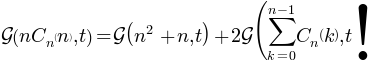

In [35]:
g_rec2 = linearity(g_rec, g_rec.rhs)
g_rec2

#### Apply the linearity again to $\mathcal{G}(n^2+n)$
Here we apply the linearity again on $\mathcal{G}(n^2+n)$ to break it into two smaller generating functions.

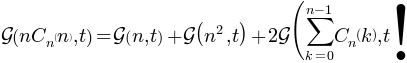

In [36]:
g_rec3 = linearity(g_rec2, G(n**2 + n, t))
g_rec3

#### Derivation property
The *derivation property* states that
$$\mathcal{G}(n\cdot a_n, t) = t\cdot \mathcal{G}'(a_n, t),$$
with $\mathcal{G}'(a_n, t)$ derivate of $\mathcal{G}(a_n, t)$ for $t$.

In [37]:
def derivation(eq, g):
    a = Wild('a')
    match = g.match(G(n*a, t))
    return eq.subs(g, t*G(a, t).diff(t)).xreplace(match)

#### Let's use it on the left side
We notice that the left side of the equation matches with the derivation property premises, so we apply it.

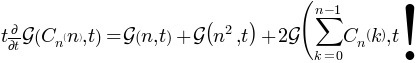

In [38]:
g_rec4 = derivation(g_rec3, g_rec3.lhs)
g_rec4

#### New notation for $\mathcal{G}(C_n(n), t)$
We introduce now a new notation for $\mathcal{G}(C_n(n), t)$ to achieve a better readability.

In [39]:
Ct = Function('C_t')
Ct(t)

#### Substitution function for $G(C_n(n)) = C_t(t)$
We also provide a handy function to substitute the new notation when possible.

In [40]:
def ct_subs(eq):
    return eq.subs(G(Cn(n), t), Ct(t))

#### Let's substitute $G(C_n(n))$ for a better readability
We substitute here the new notation just introduced.

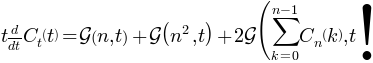

In [41]:
g_rec5 = ct_subs(g_rec4)
g_rec5

#### Couple of function to substitute known generating functions
Without going into details and demonstration, we provide here the substitution functions for two known generating functions:
$$\mathcal{G}(n, t) = \frac{t}{(1-t)²}$$
$$\mathcal{G}(n², t) = \frac{t(1+t)}{(1-t)³}$$

In [42]:
def known_n(eq):
    return eq.subs(G(n, t), t/((1-t)**2))

def known_n_squared(eq):
    return eq.subs(G(n**2, t), (t*(1+t))/((1-t)**3))

#### Let's use them both!
We substitute here the known results for these two generating functions.

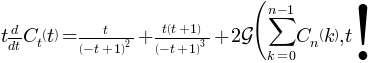

In [43]:
g_rec6 = known_n(known_n_squared(g_rec5))
g_rec6

#### Backward shift
The *backward shift property* states that
$$\mathcal{G}(a_{n-s}, t) = t^s\cdot\mathcal{G}(a_n, t),$$
with $s$ negative shift.

In [44]:
def backward_shift(eq, g, s):
    a = Wild('a')
    match = g.match(G(a, t))
    return eq.subs(g, (t**s)*G(a, t)).xreplace(match).subs(n, n+s)

#### Apply the backward shift property to the last term of the right side
Since we want the summation on the right side to go up to $n$ (and not $n-1$), we apply to it the backward shift property with $s=1$.

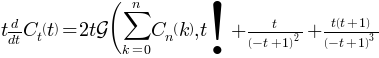

In [45]:
g_rec7 = backward_shift(g_rec6, G(Sum(Cn(k), (k, 0, n-1)), t), 1)
g_rec7

#### Euler method implementation (particular case of convolution)
The *Euler property* states that
$$\mathcal{G}(\sum_{k=0}^n a_n, t) = \frac{1}{1-t}\mathcal{G}(a_n).$$
The Euler property is a particular case of the more general *[convolution property][conv-prop]* with $b_n = 1 \;\forall n$.

[conv-prop]: https://en.wikipedia.org/wiki/Generating_function#Convolution

In [46]:
def euler(eq, g):
    a = Wild('a')
    i = Wild('i')
    f = Wild('f')
    l = Wild('l')
    match = g.match(G(Sum(a, (i, f, l)), t))
    return eq.subs(g, (1/(1-t))*G(a, t)).xreplace(match).subs(match[i], n)

#### Let's apply Euler on the last term of the right side
We can now eliminate the summation on the right side by applying Euler.

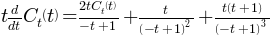

In [47]:
g_rec8 = ct_subs(euler(g_rec7, G(Sum(Cn(k), (k, 0, n)), t)))
g_rec8

#### Simplify $t$ on both sides

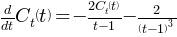

In [48]:
g_rec9 = op_eq_n(g_rec8, t, lambda x,y: x/y).simplify()
g_rec9

#### Are we lucky?
sympy provides the function $dsolve$ to solve differential equations.

Let's see if we are lucky enough to have our differential equation be solved automatically by sympy.

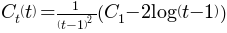

In [49]:
g_solved = dsolve(g_rec9).factor()
g_solved

Yeah! :D

$dsolve$ actually worked! Now we only need a few rewriting steps (and figure out what value should be assigned to the integration constant $C_1$) and we're done!

#### Auxiliary function to bring a coefficient inside a $log$
Before we can move on to the final step, we need to rewrite a bit that $log$ and in particular we want to reverse the sign of the $log$ argument, $t-1$, by applying some basic $log$ properties.

Let's first define a function to bring a coefficient inside a $log$ as power of its argument.

In [50]:
def power_in_log_subs(eq, log_term):
    a = Wild('a')
    b = Wild('b')
    match = log_term.match(a*log(b))
    return eq.subs(log_term, log(b**a)).xreplace(match)

#### Let's bring that $-2$ inside that $log$
We use here that function to bring the $-2$ multiplying the $log$ inside as power of its argument $t-1$.

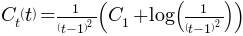

In [51]:
g_solved2 = power_in_log_subs(g_solved, -2*log(t-1))
g_solved2

#### Auxiliary function to reverse an even power
Now we write a function that reverse the sign of an even power, using the property that $a^{2x}=(-a)^{2x}$.

In [52]:
def reverse_even_power_subs(eq, power):
    a = Wild('a')
    b = Wild('b')
    match = power.match(a**(2*b))
    return eq.subs(power, (-a)**(2*b)).xreplace(match)

#### Let's reverse the sign of $(t-1)^2$
We can now use this function to reverse the sign of that $t-1$ at the denominator inside the $log$.

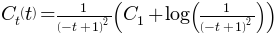

In [53]:
g_solved3 = reverse_even_power_subs(g_solved2, (t-1)**2)
g_solved3

#### Auxiliary function to bring a power outside a $log$
Here we define a specular function, that brings a power outside a $log$ as coefficient. For convenience, we pass the power we want to bring out as an argument.
```java
// ToFix: keep the original sign of a without manual change
```

In [54]:
def power_out_log_subs(eq, log_term, p):
    a = Wild('a')
    b = Wild('b')
    match = log_term.match(log(a**p))
    match[a] = 1/(1-t) # ToFix: this!
    return eq.subs(log_term, p*log(a)).xreplace(match)

#### Let's bring the $2$ outside the $log$ again
We take that $2$ outside again (keeping the $-1$ inside as power).

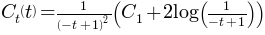

In [55]:
g_solved4 = power_out_log_subs(g_solved3, log(1/((1-t)**2)),2)
g_solved4

#### Let's find $C_1$
In order to find the correct value for the constant $C_1$ we solve the equation for $C_1$ in $0$ (since $C_n(0)$ is the only value known of our succession and $C_n(0)=C_t(0)=0$).

To do so, we express the equation in $t=0$ and the use the function $solve$ offered by sympy.

In [56]:
C1_value = solve(g_solved4.subs(t, 0).subs(Ct(0), 0), dict=True)[0]
C1_value

#### And let's substitute the value found into our equation
Finally, if we substitute the value found to $C_1$ in our equation we obtain the closed form of $C_t(t)$.

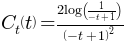

In [57]:
g_solved5 = g_solved4.xreplace(C1_value)
g_solved5

#### Known harmonic generating function
We can now observe that $\frac{log(\frac{1}{1-t})}{1-t}$ is the generating function of the Harmonic series. I.e.:
$$\frac{log(\frac{1}{1-t})}{1-t} = \mathcal{G}(H_n, t).$$
So let's define a function that substitute the generating function of the Harmonic series to that fraction.

In [58]:
def known_g_harmonic(eq):
    return eq.subs((log(1/(-t+1)))/(-t+1), G(harmonic(n), t))

#### Substitute with the generating function of the Harmonic series
We finally substitute the known generating function of the Harmonic series for a better readability.

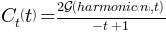

In [59]:
g_solved6 = known_g_harmonic(g_solved5)
g_solved6

#### Let's check with some coefficient

In [60]:
g_solved5.rhs.series(n=21).evalf()

Seems like it's working!

#### Coefficient extraction
Without getting our hands dirty with the "coefficient of" operator, let's define a simple function for coefficient extraction by converting the series expansion into a polynomial.

In [61]:
def get_coeff(eq, n):
    poly = Poly(eq.rhs.series(n=n+1).removeO(), t)
    coeffs = poly.coeffs()
    return coeffs[0]

In [62]:
get_coeff(g_solved5, 20).evalf()

Yep, it works! :)

### Test & comparison
In this last section we provide some test so we can easily compare the three methods seen (direct recurrence evaluation, closed form evaluation and series expansion) with some simulation with our Quicksort implementation.

#### Tests definition
We define here the routine to run a test. Basically we first run the Quicksort algorithm with checks counting on several permutations (every possible permutation for n <= 8, otherwise 10000 random permutations) and then we calculate the checks by evaluating the recurrence, then by evaluating the closed form function and finally by extracting the coefficient from the series expansion of the generating function.

We then run some tests for some values of $n$.

In [63]:
def run_test(ns, times, results, i):
    if i <= 8: # Exhaustive Testing for the QuickSort algorithm
        G = SymmetricGroup(i)
        list_symm_group = list(G.generate_dimino(af=True))
        sum_nc = 0
        for j in range(0, G.order()):
            sum_nc = sum_nc + quick(list_symm_group[j], 0, i-1)
        tot = G.order()
        mean = sum_nc/tot
    else: # Random Testing for the QuickSort algorithm
        N = 10000 # Number of random arrays to be tested
        sum_nc = 0
        for j in range(0, N):
            random = np.random.permutation(i)
            sum_nc = sum_nc + quick(random, 0, i-1)
        mean = sum_nc/N

    s1 = timeit.default_timer()
    recurrence = C_py(i)
    s2 = timeit.default_timer()
    closed = closed_form_diff.subs(n,i).rhs.evalf()
    s3 = timeit.default_timer()
    g_cn = get_coeff(g_solved5, i)
    s4 = timeit.default_timer()
    
    ns.append(i)
    results[0].append(mean)
    results[1].append(recurrence)
    results[2].append(closed)
    results[3].append(g_cn)
    times[0].append(s2-s1)
    times[1].append(s3-s2)
    times[2].append(s4-s3)

ns = []
times = [[], [], []]
results = [[], [], [], []]

for i in range(1, 21):
    run_test(ns, times, results, i)

#### Results comparison
We show here a comparison of the results yielded by the different approaches on the tests we ran.

In [64]:
for i in range(0, len(ns)):
    print ("n = %02d | Algorithm count: %07.3f | Recurrence: %07.3f | \
Closed form: %07.3f | G(C_n): %07.3f"
         % (ns[i], results[0][i], results[1][i], results[2][i], results[3][i]))

n = 01 | Algorithm count: 002.000 | Recurrence: 002.000 | Closed form: 002.000 | G(C_n): 002.000
n = 02 | Algorithm count: 005.000 | Recurrence: 005.000 | Closed form: 005.000 | G(C_n): 005.000
n = 03 | Algorithm count: 008.000 | Recurrence: 008.667 | Closed form: 008.667 | G(C_n): 008.667
n = 04 | Algorithm count: 012.000 | Recurrence: 012.833 | Closed form: 012.833 | G(C_n): 012.833
n = 05 | Algorithm count: 017.000 | Recurrence: 017.400 | Closed form: 017.400 | G(C_n): 017.400
n = 06 | Algorithm count: 022.000 | Recurrence: 022.300 | Closed form: 022.300 | G(C_n): 022.300
n = 07 | Algorithm count: 027.000 | Recurrence: 027.486 | Closed form: 027.486 | G(C_n): 027.486
n = 08 | Algorithm count: 032.000 | Recurrence: 032.921 | Closed form: 032.921 | G(C_n): 032.921
n = 09 | Algorithm count: 038.000 | Recurrence: 038.579 | Closed form: 038.579 | G(C_n): 038.579
n = 10 | Algorithm count: 044.000 | Recurrence: 044.437 | Closed form: 044.437 | G(C_n): 044.437
n = 11 | Algorithm count: 050.

Below here, we can see the same results plotted. As we can see, with enough random permutations the Quicksort count estimation is quite accurate, while the other three methods are exactly the same.

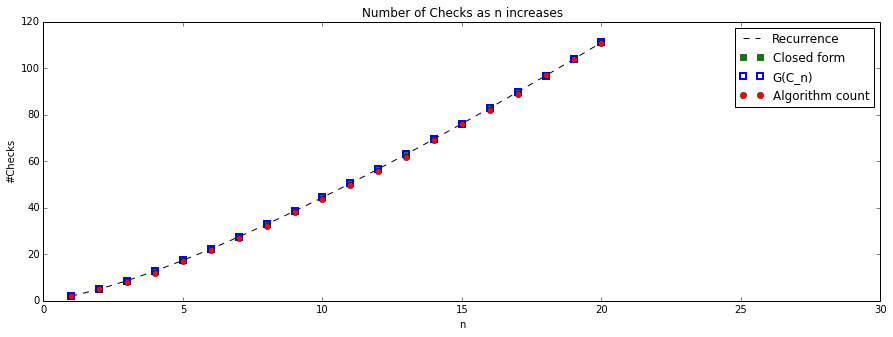

In [65]:
plt.rcParams['figure.figsize'] = 15, 5
plt.title("Number of Checks as n increases")
plt.xlabel("n")
plt.ylabel("#Checks")
plt.plot(ns, results[1], c='black', ls='--')
plt.plot(ns, results[2], c='green', marker='s', ls='')
plt.plot(ns, results[3], c='blue', marker='s',mew=2, fillstyle='none', ls='')
plt.plot(ns, results[0], c='red', marker='o', ls='')
plt.axis([0, 30, 0, 120])
plt.legend(['Recurrence', 'Closed form', 'G(C_n)', 'Algorithm count'])
plt.show()

#### Evaluation time comparison
Let's compare also the evaluation time needed to evaluate the recurrence, the closed form function and to calculate the generating function series expantion and extract the coefficient needed.

In [66]:
for i in range(0, len(ns)):
    print ("n = %02d | Recurrence: %.5f s| \
Closed form: %.5f s| G(C_n): %.5f s"
           % (ns[i], times[0][i], times[1][i], times[2][i]))

n = 01 | Recurrence: 0.00001 s| Closed form: 0.00492 s| G(C_n): 0.09504 s
n = 02 | Recurrence: 0.00000 s| Closed form: 0.00205 s| G(C_n): 0.16666 s
n = 03 | Recurrence: 0.00001 s| Closed form: 0.00268 s| G(C_n): 0.23183 s
n = 04 | Recurrence: 0.00001 s| Closed form: 0.00257 s| G(C_n): 0.32111 s
n = 05 | Recurrence: 0.00001 s| Closed form: 0.00225 s| G(C_n): 0.43897 s
n = 06 | Recurrence: 0.00002 s| Closed form: 0.00222 s| G(C_n): 0.52479 s
n = 07 | Recurrence: 0.00007 s| Closed form: 0.00264 s| G(C_n): 0.64260 s
n = 08 | Recurrence: 0.00012 s| Closed form: 0.00387 s| G(C_n): 0.82712 s
n = 09 | Recurrence: 0.00012 s| Closed form: 0.00245 s| G(C_n): 0.94518 s
n = 10 | Recurrence: 0.00028 s| Closed form: 0.00281 s| G(C_n): 1.12926 s
n = 11 | Recurrence: 0.00048 s| Closed form: 0.00239 s| G(C_n): 1.26823 s
n = 12 | Recurrence: 0.00089 s| Closed form: 0.00254 s| G(C_n): 1.44442 s
n = 13 | Recurrence: 0.00175 s| Closed form: 0.00242 s| G(C_n): 1.70009 s
n = 14 | Recurrence: 0.00645 s| Closed

As before, let's plot the evaluation times to have a better understanting.

As expected, evaluating the recurrence seems to take more time than evaluating the closed form, although not too much, at least for small $n$. We can expect to see the recurrence evaluation time "explode" for bigger values of $n$.

It's particularly interesting to notice how the computation of the series expansion of $\mathcal{G}(C_n)$ explodes right away, making this method unusable for bigger values of $n$. So we can conclude from these tests that, if we really want to use the generating function method, then we have to also try to apply the "coefficient of" operator and try to obtain the closed form of the function, because calculating the series expansion gets too heavy with bigger $n$.

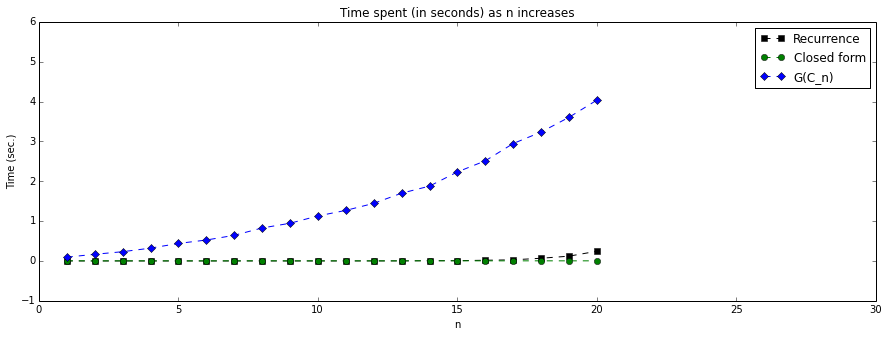

In [67]:
plt.title("Time spent (in seconds) as n increases")
plt.xlabel("n")
plt.ylabel("Time (sec.)")
plt.plot(ns, times[0], c='black', marker='s', ls='--')
plt.plot(ns, times[1], c='green', marker='o', ls='--')
plt.plot(ns, times[2], c='blue', marker='D', ls='--')
plt.axis([0, 30, -1, 6])
plt.legend(['Recurrence','Closed form','G(C_n)'])
plt.show()